In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install timm --quiet

     |████████████████████████████████| 549 kB 4.8 MB/s 
     |████████████████████████████████| 182 kB 47.3 MB/s 


In [8]:

%cd /content/drive/MyDrive/GTAI
from libraries import *
import baseFunctions as bf


/content/drive/.shortcut-targets-by-id/1Tcv2eVz-MZJi_SaLgkqfQpTgVhvwlFuJ/GTAI
pickle5 is not installed. Importing pickle instead


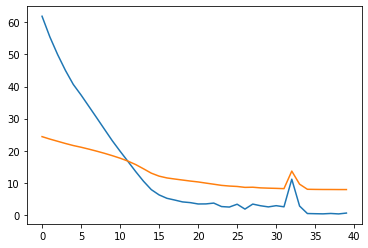

In [10]:
scores = bf.read_object("./Data/models/CNN/scores/00055_history_score.pkl")

plt.plot(scores['loss_tot_train'][15:])

plt.plot(scores['MAE_train'][15:])